In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import seaborn as sns
import warnings
import os

warnings.filterwarnings(action='ignore')
rc('font',family='AppleGothic')
rcParams['axes.unicode_minus']= False

In [2]:
path = './data_임대보증금임대료/'

train = pd.read_csv(path+'train_new.csv')
test = pd.read_csv(path+'test_new.csv')

train.shape, test.shape

((3184, 63), (776, 63))

## 임대보증금 예측
### 사용 모델
xgboost
### 입력 피처 
'총세대수', '버스정류장', '단지내주차면수', '전용면적',   
'강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',  
'공공분양', '공공임대(10년)', '공공임대(50년)', '공공임대(5년)', '공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택',  
'A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O',   
수치형 피처('총세대수', '버스정류장', '단지내주차면수', '전용면적')의 polynomial features(deg=2) 추가
### hypter parameter
objective ='reg:linear', 
colsample_bytree = 0.3,  learning_rate = 0.1, max_depth = 3,  alpha = 0.1, n_estimators = 100) 

### 1. 모델 학습 및 교차검증 MAE 산출

In [3]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score
import xgboost as xgb

sel = ['총세대수', '버스정류장', '단지내주차면수', '전용면적', 
       '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', 
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
       '공공분양', '공공임대(10년)', '공공임대(50년)', '공공임대(5년)',
       '공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택',
       'A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']

X = train[sel]
y = train[['임대보증금']]

# 피처스케일링
scaler = MinMaxScaler() #  StandardScaler MinMaxScaler
X_nor = scaler.fit_transform(X)
tmp_X_nor = X_nor[:,:4]

# polynomial features
X_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmp_X_nor)  

X_all = np.concatenate((X_poly, X_nor[:,4:]), axis=1)

# xgboost
data_dmatrix = xgb.DMatrix(data=X_all,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
            colsample_bytree = 0.3, # 각나무마다 사용하는 feature 비율
            learning_rate = 0.1,
            max_depth = 3, 
            alpha = 0.1, 
            n_estimators = 100)  # n_estimators=100

xg_reg.fit(X_all, y)
score = cross_val_score(xg_reg, X_all, y, cv=5, scoring="neg_mean_absolute_error")
m_score = np.abs(score.mean())  
print(X_all.shape, y.shape)
print("Xgboost : {}".format(m_score)) 


[00:52:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:52:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:52:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:52:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[00:52:55] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c09

### 2. 예측

In [4]:

sel = ['총세대수', '버스정류장', '단지내주차면수', '전용면적', 
       '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', 
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
       '공공분양', '공공임대(10년)', '공공임대(50년)', '공공임대(5년)',
       '공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택',
       'A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']

X_test = test[sel]
X_nor_test = scaler.fit_transform(X_test)
tmp_X_nor_test = X_nor_test[:,:4]
X_poly_test = PolynomialFeatures(degree=2, include_bias=False).fit_transform(tmp_X_nor_test)  

X_all_test = np.concatenate((X_poly_test, X_nor_test[:,4:]), axis=1)
print("X_all의 shape :", X_all_test.shape)
pred = xg_reg.predict(X_all_test)
print("pred의 shape :", pred.shape)
print("test의 shape :", test.shape)

print("임대보증금 결측치 처리 전 :", test['임대보증금'].isnull().sum())
test['임대보증금'] = pred
print("임대보증금 결측치 처리 후 :", test['임대보증금'].isnull().sum())
test.head()

X_all의 shape : (776, 55)
pred의 shape : (776,)
test의 shape : (776, 63)
임대보증금 결측치 처리 전 : 767
임대보증금 결측치 처리 후 : 0


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,H,I,J,K,L,M,N,O,df_type,idx
0,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,9386895.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,88
1,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,9386895.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,89
2,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,9386895.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,90
3,C1925,601,상가,강원도,임대상가,72.16,1,9.0,D,13655130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,91
4,C1874,619,상가,충청남도,임대상가,12.62,1,2.0,D,10672188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,101


## 임대료 예측
### 사용 모델
RandomForestRegressor
### 입력 피처 
'총세대수', '버스정류장', '단지내주차면수', '전용면적',   
'강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시','서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',  
'공공분양', '공공임대(10년)', '공공임대(50년)', '공공임대(5년)','공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택',  
'A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O' 

### 1. 모델 학습 및 교차검증 MAE 산출

In [5]:
from sklearn.ensemble import RandomForestRegressor

sel = ['총세대수', '버스정류장', '단지내주차면수', '전용면적', 
       '강원도', '경기도', '경상남도', '경상북도', '광주광역시', '대구광역시', '대전광역시', '부산광역시', 
       '서울특별시', '세종특별자치시', '울산광역시', '전라남도', '전라북도', '제주특별자치도', '충청남도', '충청북도',
       '공공분양', '공공임대(10년)', '공공임대(50년)', '공공임대(5년)',
       '공공임대(분납)', '국민임대', '영구임대', '임대상가', '장기전세', '행복주택',
       'A', 'B','C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O']

X = train[sel]
y = train[['임대료']]

# 피처스케일링
scaler = MinMaxScaler()
X_nor = scaler.fit_transform(X)

# 모델 객체 학습
rf = RandomForestRegressor()
rf.fit(X_nor, y)

# 회귀는 교차검증
rf_scores = cross_val_score(rf, X_nor, y,scoring='neg_mean_absolute_error', cv=5)
rf_score = np.abs(rf_scores.mean())
print("X_nor의 shape :", X_nor.shape )
print("y의 shape :", y.shape )
print("RandomForestRegressor : ", rf_score)


X_nor의 shape : (3184, 45)
y의 shape : (3184, 1)
RandomForestRegressor :  38796.98278260736


### 2. 예측

In [6]:
X_test = test[sel]
X_nor_test = scaler.fit_transform(X_test)

pred = rf.predict(X_nor_test)
test['임대료'] = pred

print("X_test의 shape :", X_test.shape)
print("pred의 shape :", pred.shape)
test.head()

X_test의 shape : (776, 45)
pred의 shape : (776,)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,H,I,J,K,L,M,N,O,df_type,idx
0,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,9386895.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,88
1,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,9386895.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,89
2,C1925,601,상가,강원도,임대상가,32.10,1,9.0,D,9386895.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,90
3,C1925,601,상가,강원도,임대상가,72.16,1,9.0,D,13655130.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,91
4,C1874,619,상가,충청남도,임대상가,12.62,1,2.0,D,10672188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,101


## train과 test 분리


In [7]:
path = './data/'

train_org = pd.read_csv(path+'2_train.csv')
test_org = pd.read_csv(path+'2_test.csv')

train_org.shape, test_org.shape

((2952, 62), (1008, 61))

In [8]:
print(train.shape, test.shape)
all_df = pd.concat([train, test])
print(all_df.shape)
all_df

(3184, 63) (776, 63)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,H,I,J,K,L,M,N,O,df_type,idx
0,ERR04_2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,0
1,ERR04_2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,1
2,ERR04_2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,2
3,ERR04_2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,3
4,ERR04_2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,train,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
771,C2152,120,아파트,강원도,영구임대,33.84,54,9.0,C,10563306.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,test,992
772,C1267,675,아파트,경상남도,행복주택,16.94,50,38.0,L,18831564.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,test,1000
773,C1267,675,아파트,경상남도,행복주택,26.85,66,38.0,L,18831564.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,test,1001
774,C1267,675,아파트,경상남도,행복주택,26.85,8,38.0,L,18831564.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,test,1002


In [17]:
grp = all_df.groupby("df_type")

train_new = grp.get_group(('train'))
train_new = train_new.sort_values('idx')
train_new.reset_index(drop=True, inplace=True)
train_new.drop(['df_type','idx'],axis=1, inplace=True)
print(train_new.shape)
train_new.head()

(2952, 61)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,F,G,H,I,J,K,L,M,N,O
0,ERR04_2483,900,아파트,경상북도,국민임대,39.72,134,38.0,A,15667000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ERR04_2483,900,아파트,경상북도,국민임대,39.72,15,38.0,A,15667000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ERR04_2483,900,아파트,경상북도,국민임대,51.93,385,38.0,A,27304000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ERR04_2483,900,아파트,경상북도,국민임대,51.93,15,38.0,A,27304000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ERR04_2483,900,아파트,경상북도,국민임대,51.93,41,38.0,A,27304000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
test_new = grp.get_group(('test'))
test_new = test_new.sort_values('idx')
test_new.reset_index(drop=True, inplace=True)
test_new.drop(['df_type','idx'], axis=1, inplace=True)
print(test_new.shape)
test_new.head()

(1008, 61)


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,F,G,H,I,J,K,L,M,N,O
0,C1072,754,아파트,경기도,국민임대,39.79,116,14.0,H,22830000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,C1072,754,아파트,경기도,국민임대,46.81,30,14.0,A,36048000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C1072,754,아파트,경기도,국민임대,46.90,112,14.0,H,36048000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,C1072,754,아파트,경기도,국민임대,46.90,120,14.0,H,36048000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,C1072,754,아파트,경기도,국민임대,51.46,60,14.0,H,43497000.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 시각화

<AxesSubplot:>

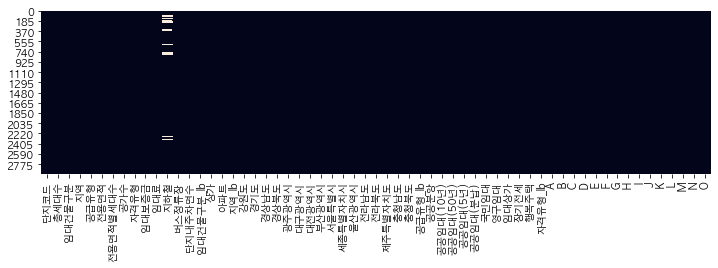

In [24]:
plt.figure(figsize=(12,3))
sns.heatmap(train_new.isnull(), cbar=False)

<AxesSubplot:>

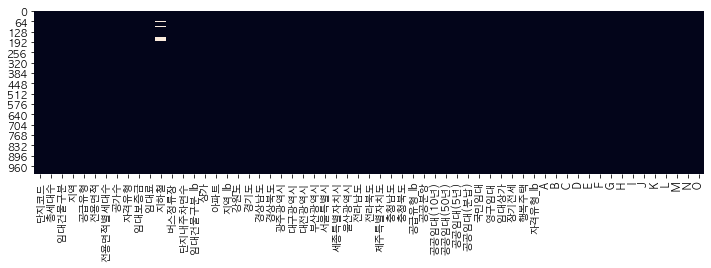

In [25]:
# test 셋에는 임대보증금과 임대료에 대해 결측치가 많다.
plt.figure(figsize=(12,3))
sns.heatmap(test_new.isnull(), cbar=False)

## csv, xlsx 파일로 내보내기

In [27]:
PATH = './data/'

train_new.to_csv(PATH+'3_train.csv', index=False)
test_new.to_csv(PATH+'3_test.csv',index=False)

train_new.to_excel(PATH+'3_train.xlsx', index=False)
test_new.to_excel(PATH+'3_test.xlsx',index=False)

os.listdir(PATH)

['2_test.xlsx',
 '3_train.csv',
 'age_gender_info.csv',
 '.DS_Store',
 '2_train.xlsx',
 '2_train_errx.xlsx',
 '3_test.xlsx',
 'test.csv',
 '2_train.csv',
 '1_test.csv',
 '3_train.xlsx',
 '1_train.csv',
 '1_train_errx.xlsx',
 '2_train_errx.csv',
 'train.csv',
 '1_test.xlsx',
 '1_train.xlsx',
 '2_test.csv',
 '3_test.csv',
 'save',
 '1_train_errx.csv',
 'sample_submission.csv']